In [46]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import json, os, sys
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

cudnn.benchmark = True
plt.ion()

path_to_be_add = '/notebook/personal/ksuchoi216/face-identification-model/'
if not path_to_be_add in sys.path:
  sys.path.insert(0, path_to_be_add)
  os.chdir(path_to_be_add)

print(f'sys.path: {sys.path}')

def load_config():
  path_for_config = './configs/config.json'
  with open(path_for_config) as f:
    cfg = json.load(f)
  return cfg

cfg = load_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sys.path: ['/notebook/personal/ksuchoi216/face-identification-model/', '/notebook', '/root/.pyenv/versions/3.9.1/lib/python39.zip', '/root/.pyenv/versions/3.9.1/lib/python3.9', '/root/.pyenv/versions/3.9.1/lib/python3.9/lib-dynload', '', '/root/.pyenv/versions/python39/lib/python3.9/site-packages']


# Loading model and data

In [47]:
from modules import Builder

builder = Builder(cfg['model'])
model = builder.getModel()
model.load_state_dict(torch.load(cfg['path_for_saving_model']))
model.classify = False
model = model.to('cpu')
model.eval()

device is cuda:0
Loading model was just completed.


InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

250
 data 
0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi
batch_size: 1 

dataset length: (185) = tr (148) + val (18) + tt (19)


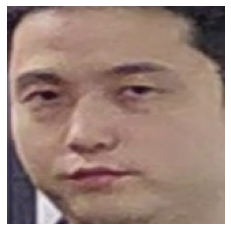

label: 3


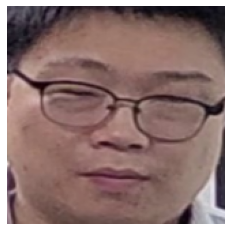

label: 2


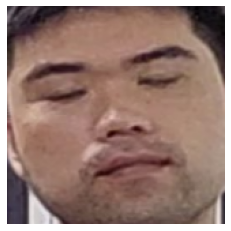

label: 1


In [48]:
from datasets import Folder_Dataset
from utils import imshow_dataloader

cfg = load_config()
folder_Dataset = Folder_Dataset(cfg['embedding'])
dataloaders, dataset_sizes, idx_to_class = folder_Dataset.createDataLoaders()

phase="train"
for i, (img, label) in enumerate(dataloaders[phase]):
  if i >= 3:
    break
  plt.imshow(img)
  plt.axis('off')
  plt.show()
  print(f'label: {label}')  

# Feature extraction and data transfromation

In [52]:
from external_lib import MTCNN
face_detector = MTCNN(image_size=240, margin=0, keep_all=True, min_face_size=40)


from utils import imshow_denormalization
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# phases = ['train', 'val', 'test']
phases = ['train']
for phase in phases:
  print(f'phase: {phase}')
  
  
  image_list = []
  embedding_list = []
  label_list = []
  
  for i, (img, label) in enumerate(dataloaders[phase]):
    face, prob = face_detector(img, return_prob = True)
    embedding = model(face)
    embedding = torch.squeeze(embedding).numpy()

    face = torch.squeeze(face).numpy()
    image_list.append(face)
    # print(f'img: {face.shape}/{type(facek)}')
    
    
    # print(f'embedding: {embedding.shape} {type(embedding)} label: {label} {type(label)}')  
    if embedding.shape[0] != 512:
      print(f'dimension errror - embedding.shape: {embedding.shape[0]}')
    embedding_list.append(embedding)
    label_list.append(label)
    
    # if i >= 2:
      # break
  
  path_for_image_data = './data/'+phase+'_image.npy'
  path_for_embedding_data = './data/'+phase+'_embedding.npy'
  path_for_label_data = './data/'+phase+'_label.npy'
  
  image_numpy = np.array(image_list)
  embedding_numpy = np.array(embedding_list)
  label_numpy = np.array(label_list)
  
  np.save(path_for_image_data, image_numpy, allow_pickle=True)
  np.save(path_for_embedding_data, embedding_numpy, allow_pickle=True)
  np.save(path_for_label_data, label_numpy, allow_pickle=True)
  # print(len(data_list))
  print(f'{phase}_image.npy saved in {path_for_image_data}')
  print(f'{phase}_embedding.npy saved in {path_for_embedding_data}')
  print(f'{phase}_label.npy saved in {path_for_label_data}')
  
  print('\n')  

phase: train
train_image.npy saved in ./data/train_image.npy
train_embedding.npy saved in ./data/train_embedding.npy
train_label.npy saved in ./data/train_label.npy




In [58]:
source = './data/'
train_path_x_img = source + 'train_embedding.npy'
train_path_x_emb = source + 'train_embedding.npy'
train_path_y = source + 'train_label.npy'
# val_path = source + 'val.npy'
# test_path = source + 'test.npy'

train_x_img = np.load(train_path_x_img, allow_pickle=True)
train_x_emb = np.load(train_path_x_emb, allow_pickle=True)
train_y = np.load(train_path_y, allow_pickle=True)
# val_data = np.load(val_path, allow_pickle=True)
# test_data = np.load(test_path, allow_pickle=True)

# PCA

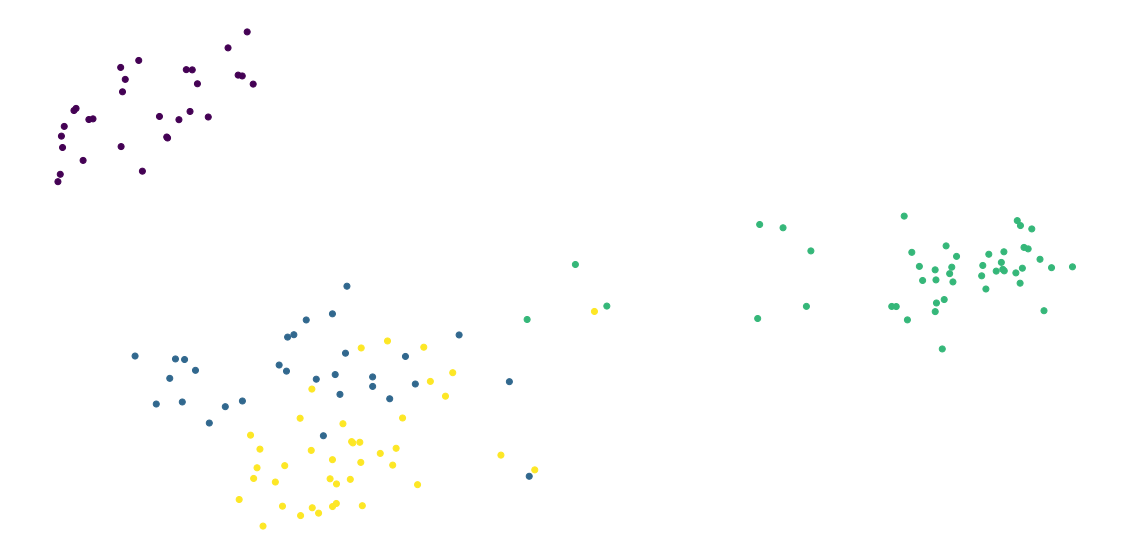

In [62]:
from utils import show_pca
show_pca(train_x_img, train_y)

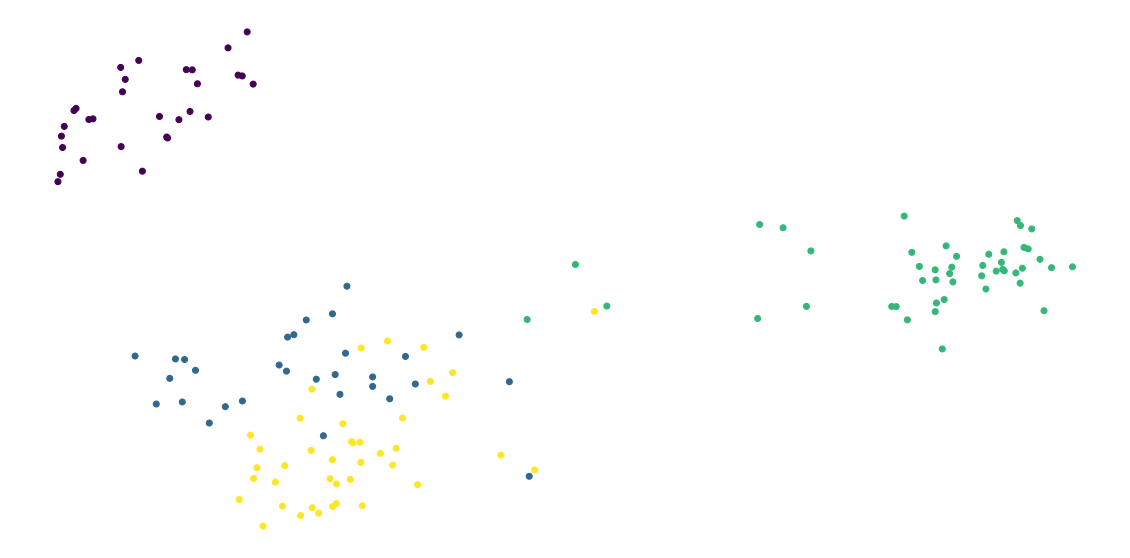

In [63]:
show_pca(train_x_emb, train_y)